Based on Elli/DeepQL-3.ipynb

In [7]:
# For plotting
!pip3 install mplhep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 33.4 MB/s eta 0:00:00a 0:00:01


In [1]:
import numpy as np

from cytools import Polytope
from cytools import fetch_polytopes

import tensorflow as tf
tfk = tf.keras
from notebooks.integer_rref import i4mat_rref

Consider case for looking $d$-fibration structures of a polytope $P$ with vertices $(v_0,\dots, v_{N-1})$. Then, state $s$ is:
$$
s = (n_0, \dots, n_{d-1}) \in \mathbb{Z}_N^d =: \mathcal{S}
$$
s.t. $n_j\neq n_k$ for $j\neq k$. A state defines a set of vectors $\{v_{n_j}\}_j$, whose intersection with $P$ defines the subpolytope.

An action on the state space $\mathcal{S}$ is a group action:
$$
\mathbb{Z}_N^d \times \mathcal{S} \rightarrow \mathcal{S}
$$
induced by the group product. In particular, we have:
$$
(m_0,\dots, m_{d-1})\cdot (n_0,\dots, n_{d-1}) = (m_0 + n_0,\dots, m_{d-1} + n_{d-1})
$$
Note that $\mathbb{Z}_N^d$ is cyclic and generated by elements:
$$
(1, 0, \dots, 0)\\
(0, 1,\dots, 0)\\
\dots\\
(0, 0, \dots, 1)
$$
we shall use these as possible actions.

> *Note*: There really is no reason for this to work, as the ordering of the vertices is completely arbitrary. Q: is there a "natural" way to order the vertices, in order to have a notion of "neighboring" subspaces?

In [2]:
from copy import deepcopy

class FibrationEnvironment(object):
    def __init__(self, polytope, fibration_dim):
        self._p = polytope
        self._points = polytope.points()[1:]
        self._d = fibration_dim
        self._num_actions = fibration_dim

    def random_state(self):
        return np.random.choice(self._points.shape[0], size=(self._d))

    @staticmethod
    def reduce_polytope(vertices):
        vertices_copy = np.array(vertices, copy=True)
        W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
        local_vertices = np.round(vertices@np.linalg.pinv(W))
        idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))

        return np.delete(local_vertices, idx, axis=1)


    def R(self, state):
        vertices_basis = []
        for pt_id in state:
            vertices_basis.append(self._points[pt_id])

        vertices_basis = np.asarray(vertices_basis)
        vertices = []
        for pt in self._points:
            if np.linalg.matrix_rank(
                np.append(vertices_basis, [pt], axis=0)) == self._d:
                vertices.append(pt)
        vertices = np.asarray(vertices)

        reward = 0.0
        reward -= (np.linalg.matrix_rank(vertices) - self._d)**2


        p_reduced = Polytope(np.asarray(self.reduce_polytope(vertices), np.int32))
        reward += (1.0 if p_reduced.is_reflexive() else -1.0)
        reward -= (p_reduced.dimension() - self._d)**2

        return reward, reward > 0

    def act(self, state, action):
        new_state = deepcopy(state)
        new_state[action] = ((new_state[action] + 1) % (self._points.shape[0]))

        return new_state, self.R(new_state)

    @property
    def num_actions(self):
        return self._d

    @property
    def all_actions(self):
        return [i for i in range(self._d)]

In [3]:
import random
from collections import deque

class QNet(tfk.Model):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self._dense1 = tfk.layers.Dense(64, activation='relu', input_shape = input_shape)
        self._dense2 = tfk.layers.Dense(128, activation='relu')
        self._dense3 = tfk.layers.Dense(output_shape, activation='linear')

    def call(self, x):
        x = self._dense1(x)
        x = self._dense2(x)
        x = self._dense3(x)
        return x


class Agent(object):
    def __init__(self, input_shape, output_shape, buffer_size = 2**11, lr=1e-3):
        super().__init__()
        self._model         = QNet(input_shape, output_shape)
        self._target_model  = QNet(input_shape, output_shape)

        self._memory = deque(maxlen=buffer_size)
        self._gamma = 0.95
        self._epsilon = 1.0
        self._epsilon_min = 0.01
        self._epsilon_decay = 0.995
        self._policy_lr = 0.7

        self._input_shape = input_shape
        self._output_shape = output_shape

        self._optim = tfk.optimizers.Adam(learning_rate = lr)
        self._model.compile(
            loss = tfk.losses.MeanSquaredError(),
            optimizer = self._optim,
            metrics = [tfk.metrics.MeanAbsoluteError()])

        self.update_target_model()

    def update_target_model(self):
        self._target_model.set_weights(self._model.get_weights())

    def store(self, state, action, reward, next_state, terminated):
        self._memory.append([state, action, reward, next_state, terminated])

    @property
    def current_memory_size(self):
        return len(self._memory)

    def act(self, state):
        if np.random.rand() <= self._epsilon:
            return random.randrange(self._output_shape)

        state = np.reshape(state, (1, state.shape[0]))
        Q_a = self._model(state)
        return np.argmax(Q_a)

    def replay(self, batch_size):
        minibatch = random.sample(self._memory, batch_size)

        states_batch = []
        next_states_batch = []
        for state, _, _, next_state, _ in minibatch:
            states_batch.append(state)
            next_states_batch.append(next_state)
        states_batch = np.asarray(states_batch)
        next_states_batch = np.asarray(next_states_batch)

        Q_s = self._model.predict(states_batch, verbose = 0)
        Q_s_next = self._target_model.predict(next_states_batch, verbose = 0)

        X = []
        Y = []

        for idx, (state, action, reward, next_state, terminated) in enumerate(minibatch):
            maxQ_next = reward if terminated else (
                reward + self._gamma * np.max(Q_s_next[idx]))

            Q_s[idx][action] = (1.0 - self._policy_lr)*Q_s[idx][action] + self._policy_lr * maxQ_next

            X.append(state)
            Y.append(Q_s[idx])


        history = self._model.fit(np.asarray(X), np.asarray(Y), batch_size = batch_size, shuffle = True, verbose = 0)
        if self._epsilon > self._epsilon_min:
            self._epsilon *= self._epsilon_decay

        return history

In [4]:
p = Polytope([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1],
    [-1,-1,0,0],
    [-1,-1,-1,-1],
])

f_env = FibrationEnvironment(p, 2)

state = f_env.random_state()
f_env.R(state)

agent = Agent(
    input_shape = state.shape[0],
    output_shape = f_env.num_actions)

/home/cytools/cytools-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
from tqdm import trange
batch_size = 128
steps_to_update_target_model = 0
MAX_ITER = 32
MIN_MEMORY_SIZE = 1024


loss_vals = []
with trange(1024) as t_epochs:
    for epoch in t_epochs:
        state = f_env.random_state()

        terminated = False
        total_loss = 0.0
        while not terminated:
            steps_to_update_target_model += 1
            action = agent.act(state)
            new_state, (fitness, done) = f_env.act(state, action)

            reward = 0.
            if done:
                reward = 10.
                terminated = True
            else:
                reward = -1. + (fitness - f_env.R(state)[0])


            agent.store(state, action, reward, new_state, terminated)

            if terminated or (steps_to_update_target_model % 4 == 0):
                if agent.current_memory_size > MIN_MEMORY_SIZE:
                    history = agent.replay(batch_size)
                    total_loss += history.history['loss'][-1]

            # Move
            state = deepcopy(new_state)

            if terminated:
                if steps_to_update_target_model >= 100:
                    agent.update_target_model()
                    steps_to_update_target_model = 0
        t_epochs.set_description(f"Loss: {total_loss}")
        loss_vals.append(total_loss)


Loss: 0.5755276679992676: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [02:15<00:00,  7.55it/s]


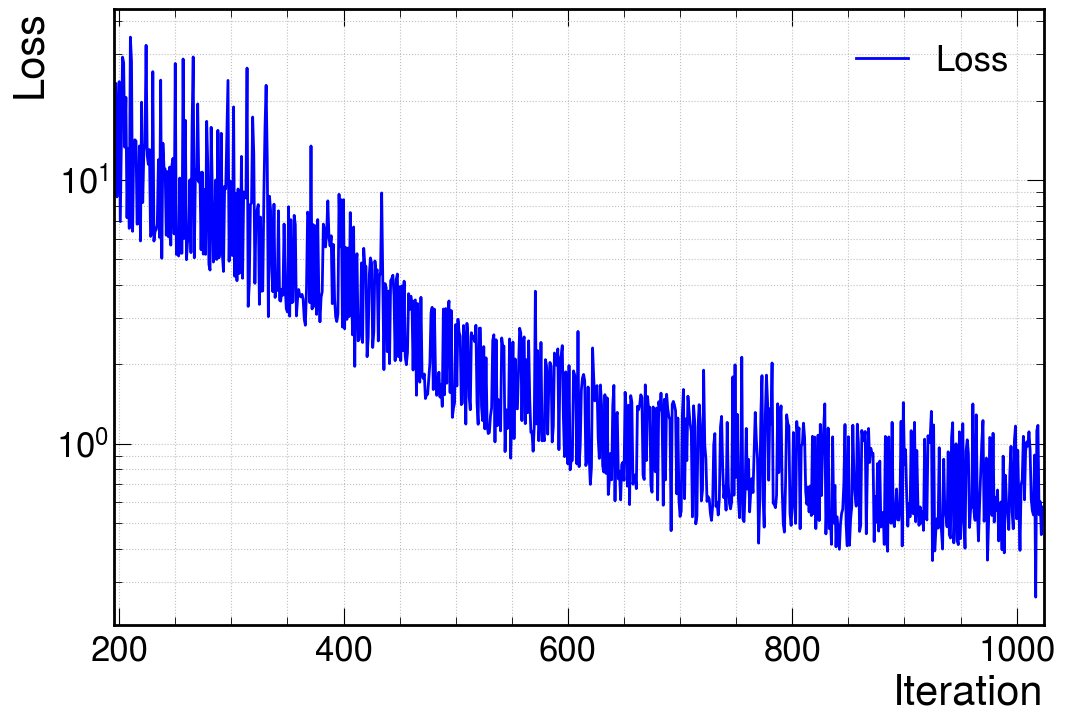

In [25]:
import numpy as np
import matplotlib.pyplot as plt


import mplhep as hep
hep.style.use("CMS")


plt.rcParams.update({
    "text.usetex": False, # LaTeX not available in cytools env
    # "font.family": "Helvetica",
    'font.size': 30
})


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(loss_vals, 'b-', label="Loss", linewidth=2)
ax.set_xlim([195, len(loss_vals)])
ax.set_yscale('log')

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax.grid(True, 'both')
ax.legend()
# plt.savefig("loss.pdf", bbox_inches='tight')

In [43]:
state = f_env.random_state()
# state = np.asarray([0,3])
print(state, f_env.R(state)[-1])

num_steps = 0

path = [state]

done = False
while not done:
    action = agent.act(state)
    next_state, (_, done) = f_env.act(state, action)
    state = next_state

    num_steps += 1
    path.append(state)

[0 3] False


In [44]:
print("Is Reflexive:    {}\nNum steps taken: {}".format(
    f_env.R(state)[1], num_steps))

Is Reflexive:    True
Num steps taken: 2


In [45]:
path

[array([0, 3]), array([1, 3]), array([1, 4])]